<a href="https://colab.research.google.com/github/kznts9v-1lya/formal-lang-course/blob/task5-rpq-research/researches/rpq_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автор [kznts9v_1lya](https://github.com/kznts9v-1lya).

---

# Экспериментальное исследование производительности CPU и GPU версий алгоритма Regular Path Quering.

---

## Введение

Имеется **размеченный граф** $G$, задающий регулярный язык $L_G$.

Имеется **регулярное выражение** $Q$, задающее регулярный язык ограничений $L_Q$.

Задача $Regular Path Quering$ решает проблему поиска путей в заданных ограничениях. Они представляются в виде пар достижимых вершин графа, представляющего $L_G\cap L_Q$.

$RPQ = \{(v_i, v_j)|\exists\pi:w(v_i\pi v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_Q$

Известно свойство, что регулярные языки замкнуты относительно пересечения и по ним можно построить конечный автомат, допускающий эти языки. Именно поэтому $RPQ$ строит язык пересечения, задаваемый пересечением двух конечных автоматов $КА_{G}$ и $КА_{Q}$, допускающих $L_G$ и $L_Q$ соответсвенно, --- также конечным автоматом $КА_{I}$.

Обратимся к определению, $КА_3 = КА_1\cap КА_2 = (S^{1}\times S^{2}, \Delta^{3}, S^{1}_S\times S^{2}_S, S^{1}_F\times S^{2}_F)$, где функция переходов задаётся как
$\Delta^{3}: (v_i, v_j)\times l_{abel}\rightarrow (u_i, u_j)$

$
\begin{cases}
v_i\in S^{1}\times l\rightarrow u_i\in S^{1}\in\Delta^{1} \\
v_j\in S^{2}\times l\rightarrow u_j\in S^{2}\in\Delta^{2}
\end{cases}$

Для нахождения функции переходов $\Delta^{I}$ используется алгоритм, основанный на тензорном произведении булевых матриц смежности конечных автоматов $КА_{G}$ и $КА_{Q}$, также известном как произведение Кронекера, и последующем построении транизитивного замыкания.

В данной работе будет экспериментально исследована скорость работы описанного алгоритма решения проблемы $RPQ$, реализованный в двух вариантах --- на CPU и GPU.

---

## Постановка цели исследования

Для достижения поставленной цели --- экспериментального исследования скорости работы описанного алгоритма решения проблемы $RPQ$ --- необходимо выполнить следующие подзадачи:

- Используя разряженные матрицы [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) реализовать алгоритм пересечения двух конечных автоматов через тензорное произведение с использованием $CPU$;
- Используя библиотеку [pyCuBool](https://pypi.org/project/pycubool/) реализовать алгоритм пересечения двух конечных автоматов через тензорное произведение с использованием технологии $CUDA$ для $GPU$;
- Сформировать датасет, необходимый для проведения экспериментов;
- Произвести сравнительный анализ производительности версий алгоритма.

---

## Исследуемые версии алгоритма

Элементами матрицы смежности для конечного автомата являются подмножества его меток, по которым возможен переход в данных состояниях. Чтобы не вводить операцию пересечения множеств в тензорном произведении, матрицы смежности двух конечных автоматов приводятся к виду булевых матриц по всем символам.

На практике, булевы матрицы являются сильно разреженными. Поэтому сравниваемые версии алгоритма используют библиотеки для работы с разреженными матрицами:

- [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)
- [pyCuBool](https://pypi.org/project/pycubool/)

In [13]:
# Развёртывание репозитория
!git clone https://github.com/kznts9v-1lya/formal-lang-course.git
!cd formal-lang-course && git checkout task5-rpq-research

fatal: destination path 'formal-lang-course' already exists and is not an empty directory.
Already on 'task5-rpq-research'
Your branch is up to date with 'origin/task5-rpq-research'.


In [14]:
# Установка внешних зависимостей
!pip install -r formal-lang-course/requirements.txt

In [15]:
# Инициализация директории в окружении
import sys
sys.path.insert(1, 'formal-lang-course')

---

## Описание данных для экспериментов

В качестве $L_G$ использовуются графы из [RDF](https://jetbrains-research.github.io/CFPQ_Data/dataset/RDF.html) датасета.

In [16]:
# Названия использующихся графов

GRAPH_NAMES = (
    # "skos",
    # "generations",
    "travel",
    "univ_bench",
    # "atom_primitive",
    # "biomedical_mesure_primitive",
    "foaf",
    "people_pets",
    # "funding",
    # "wine",
    "pizza",
    "core",
    "pathways",
    # "enzyme",
    # "eclass_514en",
    # "go_hierarchy",
    # "go",
    # "geospecies",
)

In [17]:
# Объекты использующихся графов

from project.graph_tools import get_from_dataset

GRAPHS = []

for graph_name in GRAPH_NAMES:
  GRAPHS.append(get_from_dataset(graph_name))

In [18]:
# Информация об использующихся графах

for graph in GRAPHS:
  print(str(graph)) 

Graph travel: - number of nodes: 131
	- number of edges: 277
	- edge labels: {rdflib.term.URIRef('http://www.w3.org/2002/07/owl#onProperty'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#first'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#complementOf'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#intersectionOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#range'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#disjointWith'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#unionOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#domain'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#differentFrom'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#someValuesFrom'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#oneOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#versio


В запросах используются все общепринятые конструкции регулярных выражений (замыкание, конкатенация, альтернатива).

In [19]:
# Создание генераторов регулярных выражений --- запросов к графам

from pyformlang.regular_expression.regex_objects import Symbol
from pyformlang.regular_expression import Regex

def _regex_from_label(label):
  regex = Regex("")
  regex.head = Symbol(str(label))

  return regex

def query_one(labels):
  """
  (l0 | l1)* l2
  """

  label_regex_0 = _regex_from_label(labels[0])
  label_regex_1 = _regex_from_label(labels[1])
  label_regex_2 = _regex_from_label(labels[2])

  return label_regex_0.union(label_regex_1).kleene_star().concatenate(label_regex_2)

def query_two(labels):
  """
  l0 | l2 | l1*
  """

  label_regex_0 = _regex_from_label(labels[0])
  label_regex_1 = _regex_from_label(labels[1])
  label_regex_2 = _regex_from_label(labels[2])

  return label_regex_0.union(label_regex_2).union(label_regex_1.kleene_star())

def query_three(labels):
  """
  l0 l1 l2 (l3 | l1)*
  """ 

  label_regex_0 = _regex_from_label(labels[0])
  label_regex_1 = _regex_from_label(labels[1])
  label_regex_2 = _regex_from_label(labels[2])
  label_regex_3 = _regex_from_label(labels[3])

  return label_regex_0.concatenate(label_regex_1).concatenate(label_regex_2).\
  concatenate((label_regex_3.union(label_regex_1)).kleene_star())

def query_four(labels):
  """
  (l0 | l3)* | (l1 | l2)*
  """

  label_regex_0 = _regex_from_label(labels[0])
  label_regex_1 = _regex_from_label(labels[1])
  label_regex_2 = _regex_from_label(labels[2])
  label_regex_3 = _regex_from_label(labels[3])

  left_regex_part = (label_regex_0.union(label_regex_3)).kleene_star()
  right_regex_part = (label_regex_1.union(label_regex_2)).kleene_star()

  return left_regex_part.union(right_regex_part)

QUERIES = [query_one, query_two, query_three, query_four]

---

## Сравнение производительности версий алгоритма

Для сравнения производительности версий алгоритма к каждому графу создается по 4 запроса, каждый из которых выполняется 5 раз. 

В таблице преведены результаты работы алгоритма в зависимости от графа и сгенерированного запроса.

Данные результаты получены в **Google Colab (CPU + GPU platform)**



In [26]:
from project.path_querying_tools import regular_path_querying

print("=== VERSION BASED ON CPU (scipy.sparse) ===")

for graph in GRAPHS:
  labels = list(graph.description.edge_labels)

  for query_generator in QUERIES:
    query = query_generator(labels)

    print(str(graph))
    print(f"Query: {query_generator.__doc__}")
    print("Perfomance:")
    %timeit -n 5 result = regular_path_querying(graph.graph, query, mode="cpu")
    print("-----------")

=== VERSION BASED ON CPU (scipy.sparse) ===
Graph travel: - number of nodes: 131
	- number of edges: 277
	- edge labels: {rdflib.term.URIRef('http://www.w3.org/2002/07/owl#onProperty'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#first'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#complementOf'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#intersectionOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#range'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#disjointWith'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#unionOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#domain'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#differentFrom'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#someValuesFrom'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#oneOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.

### СPU-версия алгоритма $RPQ$ ($scipy.sparse$)

Время работы алгоритма (**мс**.) в зависимости от графа и регулярного выражения:

| regex \ graph (ms.) | travel | univ_bench | foaf | people_pets | pizza | core | pathways |
|---------------|--------|------------|------|-------------|-------|------|---------|
| (l0 \| l1)* l2 | 28.4 | 31.3 | 59.8 | 67.4 | 181 | 314 | 2930 |
| l0 \| l2 \| l1* | 28.7 | 32.2 | 60.5 | 68.6 | 182 | 324 | 2970 |
| l0 l1 l2 (l3 \| l1)* | 29.2 | 33.3 | 60.8 | 70.8 | 185 | 324 | 2998 |
| (l0 \| l3)* \| (l1 \| l2)* | 29.2 | 32.9 | 61 | 69.5 | 184 | 317 | 2995 |

In [28]:
from project.path_querying_tools import regular_path_querying

print("=== VERSION BASED ON GPU (pyCuBool) ===")

for graph in GRAPHS:
  labels = list(graph.description.edge_labels)

  for query_generator in QUERIES:
    query = query_generator(labels)

    print(str(graph))
    print(f"Query {query_generator.__doc__}")
    print("Perfomance:")
    %timeit -n 5 result = regular_path_querying(graph.graph, query, mode="gpu")
    print("-----------")

=== VERSION BASED ON GPU (pyCuBool) ===
Graph travel: - number of nodes: 131
	- number of edges: 277
	- edge labels: {rdflib.term.URIRef('http://www.w3.org/2002/07/owl#onProperty'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#first'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#complementOf'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#intersectionOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#range'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#disjointWith'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#unionOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#domain'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#differentFrom'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#someValuesFrom'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#oneOf'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIR

### GPU-версия алгоритма $RPQ$ ($pyCuBool$)

Время работы алгоритма (**мс**.) в зависимости от графа и регулярного выражения:

| regex \ graph (ms.) | travel | univ_bench | foaf | people_pets | pizza | core | pathways |
|---------------|--------|------------|------|-------------|-------|------|---------|
| (l0 \| l1)* l2 | 24.1 | 26.9 | 52.5 | 61.7 | 157 | 284 | 2810 |
| l0 \| l2 \| l1* | 23.9 | 27.4 | 51.9 | 62.3 | 163 | 293 | 2830 |
| l0 l1 l2 (l3 \| l1)* | 26.7 | 29 | 53.7 | 64.4 | 165 | 290 | 2870 |
| (l0 \| l3)* \| (l1 \| l2)* | 26 | 29.4 | 53.5 | 64.7 | 167 | 289 | 2830 |

### Зависимость времени выполнения от параметров графа

Для регулярного выражения $(l0 | l1)* l2$ построены графики зависимости времени решения проблемы $RPQ$ от количества вершин и ребёр графа на примере **GPU-версии алгоритма ($pyCuBool$)**.

Рассмотрим зависимость производительности от количества вершин.

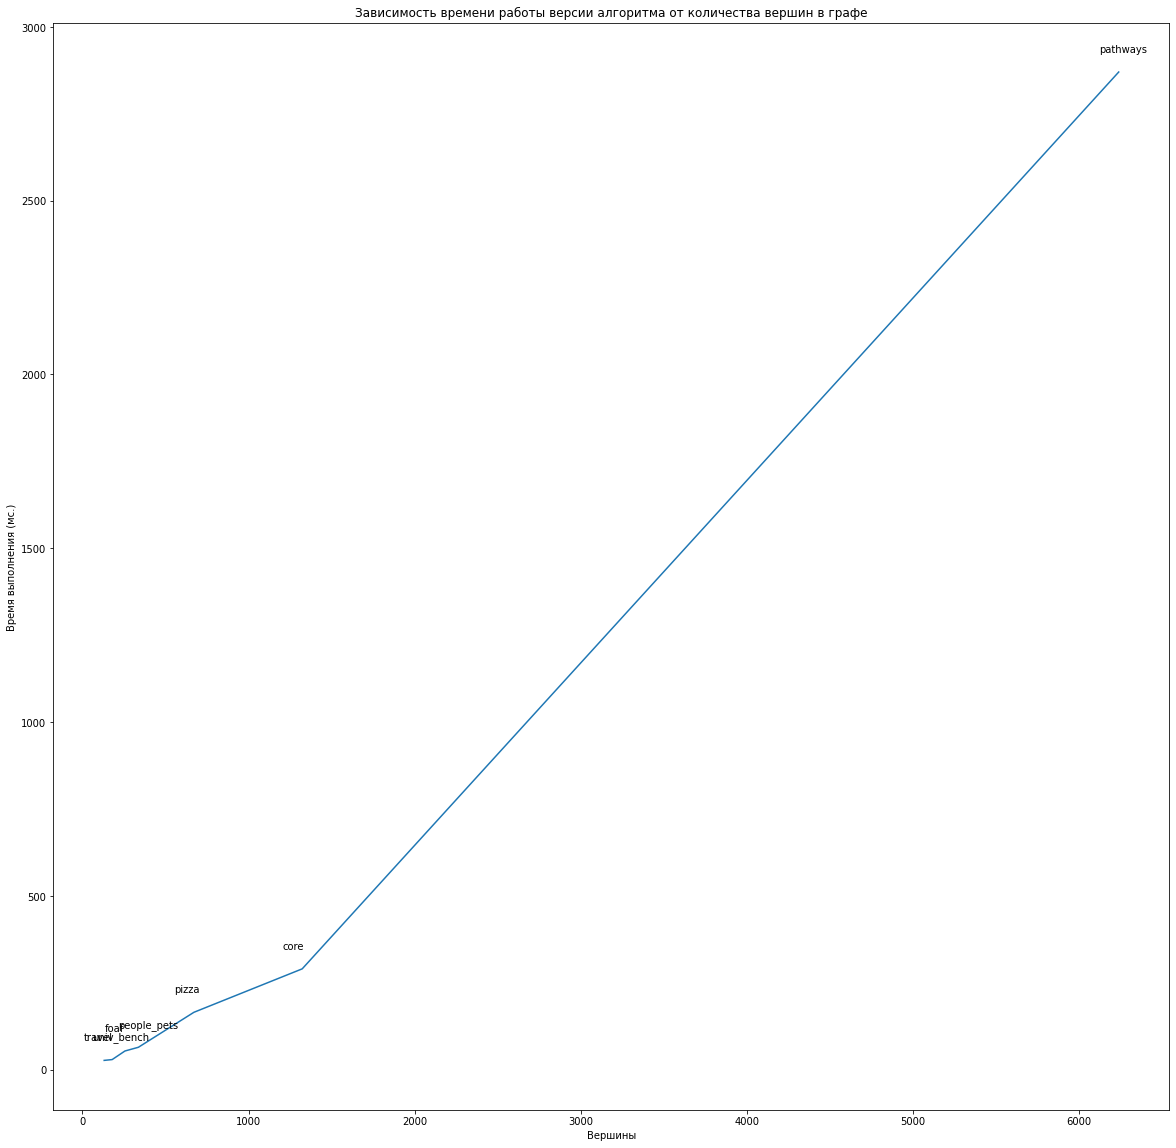

In [41]:
# Среднее время выполнения GPU-версии алгоритма RPQ (pyCuBool)
# на запросе l0 l1 l2 (l3 | l1)*

import matplotlib.pyplot as plt

X = [graph.description.nodes for graph in GRAPHS]
Y = [26.7, 29, 53.7, 64.4, 165, 290, 2870]

plt.figure(figsize=(20, 20))
plt.plot(X, Y)
plt.xlabel("Вершины")
plt.ylabel("Время выполнения (мс.)")
plt.title("Зависимость времени работы версии алгоритма от количества вершин в графе")

for x, y, name in zip(X, Y, GRAPH_NAMES):
  plt.annotate(name, (x, y), textcoords="offset points", xytext=(-20, 20))

По графику наблюдается наличие зависимости времени выполнения алгоритма от числа вершин графа. 

Рассмотрим зависимость производительности от количества рёбер.


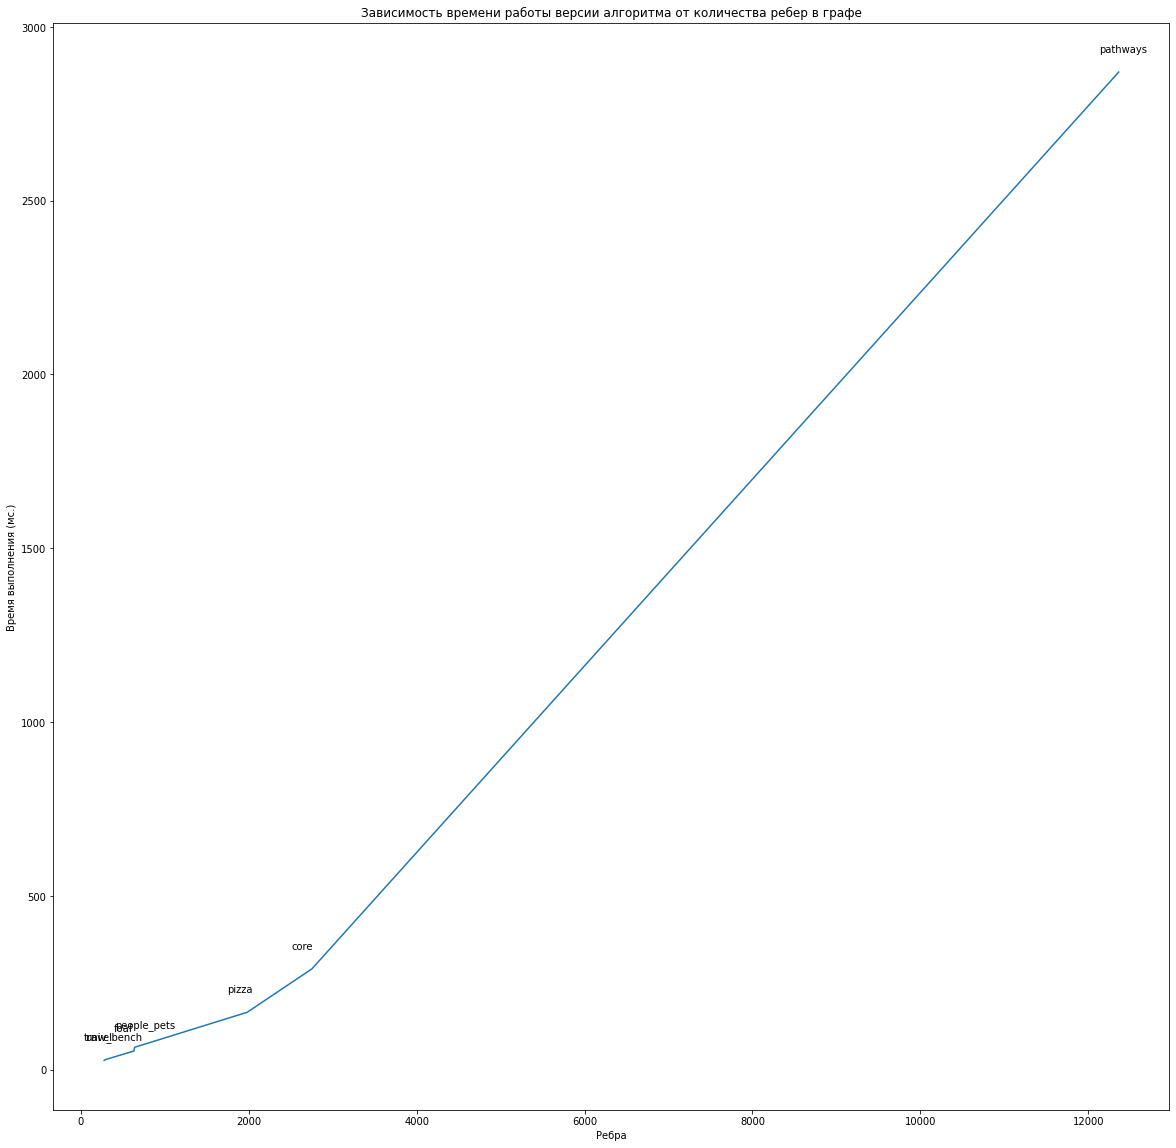

In [43]:
# Среднее время выполнения GPU-версии алгоритма RPQ (pyCuBool)
# на запросе l0 l1 l2 (l3 | l1)*

import matplotlib.pyplot as plt

X = [graph.description.edges for graph in GRAPHS]
Y = [26.7, 29, 53.7, 64.4, 165, 290, 2870]

plt.figure(figsize=(20, 20))
plt.plot(X, Y)
plt.xlabel("Ребра")
plt.ylabel("Время выполнения (мс.)")
plt.title("Зависимость времени работы версии алгоритма от количества ребер в графе")

for x, y, name in zip(X, Y, GRAPH_NAMES):
  plt.annotate(name, (x, y), textcoords="offset points", xytext=(-20, 20))

Наблюдается ещё более выраженная зависимость времени выполнения от количества рёбер в графе, чем от количества вершин.

## Итоги исследования

Алгоритм решения проблемы $RPQ$ показал лучшие результаты в случае использования реализации с применением $pyCuBool$ для выполнения операций с булевыми матрицами. Данный результат объясняется тем, что библиотека $pyCuBool$ в своей реализации применяет технологию $NVIDIA$ $CUDA$, использующую графический ускоритель для вычислений.